In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt


In [2]:
load_dotenv()
output_csv = os.getenv("INPUT_CSV")
df = pd.read_csv(output_csv)

In [3]:
video_ids = df['video_id'].unique()

X_list = []
y_list = []

for vid in video_ids:
    video_df = df[df['video_id'] == vid].sort_values('frame')
    
    features = video_df.drop(columns=['video_id', 'frame', 'label']).values
    
    if features.shape[0] == 90:
        X_list.append(features)
        y_list.append(video_df['label'].iloc[0]) 

X = np.array(X_list)
y = np.array(y_list)
print(X.shape, y.shape)

(1600, 90, 26) (1600,)


In [5]:
num_samples, timesteps, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled.reshape(num_samples, timesteps, num_features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = Sequential([
    Masking(mask_value=0., input_shape=(timesteps, num_features)), 
    LSTM(128, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # klasyfikacja wieloklasowa
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    verbose=1
)

c:\Users\skrza\Documents\GitHub\ENGINEERING-WORK\.venv\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 90, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,719 (327.03 KB)

 Trainable params: 83,719 (327.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2494 - loss: 1.9079 - val_accuracy: 0.1328 - val_loss: 1.9063
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2161 - loss: 1.7988 - val_accuracy: 0.2227 - val_loss: 1.7659
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2925 - loss: 1.7035 - val_accuracy: 0.2344 - val_loss: 1.9053
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2541 - loss: 1.8623 - val_accuracy: 0.2344 - val_loss: 1.9197
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2621 - loss: 1.8594 - val_accuracy: 0.1172 - val_loss: 2.0101
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1963 - loss: 1.9408 - val_accuracy: 0.2344 - val_loss: 1.9274
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2602 - loss: 1.8747 - val_accuracy: 0.2461 - val_loss: 1.6268
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2195 - loss: 1.9211 - val_accu

In [6]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9106 - loss: 0.2195
Test loss: 0.2195
Test accuracy: 0.9125


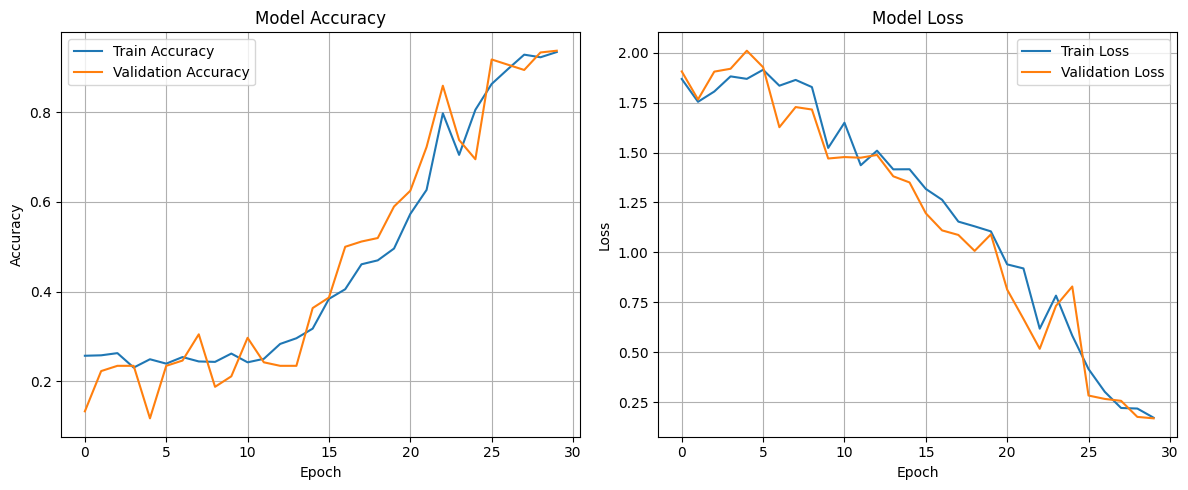

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
y_pred_probs = model.predict(X_test)       # shape (num_samples, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)   # wybieramy klasę z największym prawdopodobieństwem


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [14]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

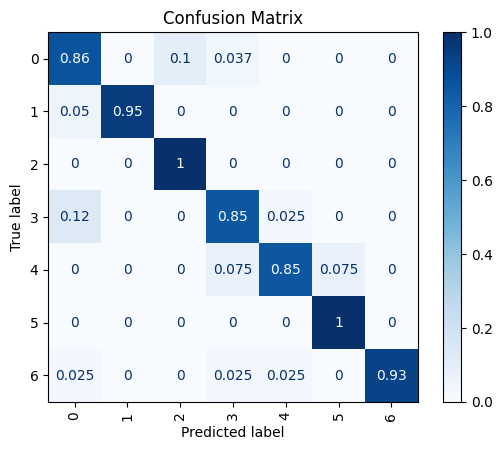

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        80
           1       1.00      0.95      0.97        40
           2       0.83      1.00      0.91        40
           3       0.83      0.85      0.84        40
           4       0.94      0.85      0.89        40
           5       0.93      1.00      0.96        40
           6       1.00      0.93      0.96        40

    accuracy                           0.91       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.92      0.91      0.91       320

